In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar-100/meta
/kaggle/input/cifar-100/file.txt
/kaggle/input/cifar-100/test
/kaggle/input/cifar-100/train


In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [16]:
import pickle, numpy as np

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def load_cifar100(path="/kaggle/input/cifar-100"):
    train = unpickle(f"{path}/train")
    test = unpickle(f"{path}/test")

    X_train_cust = train[b'data'].reshape(-1, 3, 32, 32).transpose(0,2,3,1)
    y_train_cust = np.array(train[b'fine_labels'])
    X_test_cust = test[b'data'].reshape(-1, 3, 32, 32).transpose(0,2,3,1)
    y_test_cust = np.array(test[b'fine_labels'])
    return X_train_cust, y_train_cust, X_test_cust, y_test_cust

X_train_cust, y_train_cust, X_test_cust, y_test_cust= load_cifar100()
print(X_train_cust.shape, y_train_cust.shape)  


(50000, 32, 32, 3) (50000,)


In [ ]:
import pickle

def load_meta(path="/kaggle/input/cifar-100/meta"):
    with open(path, 'rb') as fo:
        meta = pickle.load(fo, encoding='bytes')
    fine_names = [n.decode('utf-8') for n in meta[b'fine_label_names']]
    coarse_names = [n.decode('utf-8') for n in meta[b'coarse_label_names']]
    return fine_names, coarse_names

fine_names, coarse_names = load_meta()
print("Fine classes:", fine_names[:10])    
print("Coarse classes:", coarse_names)     


Fine classes: ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle']
Coarse classes: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


In [12]:
coarse_names

['aquatic_mammals',
 'fish',
 'flowers',
 'food_containers',
 'fruit_and_vegetables',
 'household_electrical_devices',
 'household_furniture',
 'insects',
 'large_carnivores',
 'large_man-made_outdoor_things',
 'large_natural_outdoor_scenes',
 'large_omnivores_and_herbivores',
 'medium_mammals',
 'non-insect_invertebrates',
 'people',
 'reptiles',
 'small_mammals',
 'trees',
 'vehicles_1',
 'vehicles_2']

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Input

In [14]:
X_train_cust = X_train_cust.astype("float32") / 255.0
X_test_cust = X_test_cust.astype("float32") / 255.0


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen= ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(X_train_cust)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf

def build_cifar100_cnn():
    model = models.Sequential([
        layers.Input((32,32,3)),
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(64, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.3),

        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(128, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.4),

        layers.Conv2D(256, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Conv2D(256, (3,3), padding='same'),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D(pool_size=(2,2)),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(512),
        layers.BatchNormalization(),
        layers.Activation('relu'),
        layers.Dropout(0.5),
        layers.Dense(100, activation='softmax')
    ])
    return model
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_cifar100_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
cust_model = build_cifar100_cnn()
cust_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
cust_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 8, 8, 256)      │             

 Total params: 3,300,004 (12.59 MB)

 Trainable params: 3,297,188 (12.58 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [18]:
y_test.shape
y_train.shape

(50000,)

In [22]:
hist=cust_model.fit(datagen.flow(X_train_cust,y_train_cust,batch_size=32),epochs=20,validation_data=(X_test_cust,y_test_cust),callbacks=[early_stop,checkpoint])

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0619 - loss: 4.3908
Epoch 1: val_accuracy improved from -inf to 0.20530, saving model to best_cifar100_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - accuracy: 0.0620 - loss: 4.3903 - val_accuracy: 0.2053 - val_loss: 3.2819
Epoch 2/20
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1851 - loss: 3.3621
Epoch 2: val_accuracy improved from 0.20530 to 0.26250, saving model to best_cifar100_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.1852 - loss: 3.3620 - val_accuracy: 0.2625 - val_loss: 2.9662
Epoch 3/20
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2593 - loss: 2.9451
Epoch 3: val_accuracy improved from 0.26250 to 0.32990, saving model to best_cifar100_model.h5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.2594 - loss: 2.9451 - val_accuracy: 0.3299 - val_loss: 2.5543
Epoch 4/20
1562/1563 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3087 - loss: 2.6879
Epoch 4: v

In [24]:
test_loss_custom, test_acc_custom = cust_model.evaluate(X_test_cust, y_test_cust, verbose=0)
print(f"Test Accuracy: {test_acc_custom:.4f}")

Test Accuracy: 0.5742


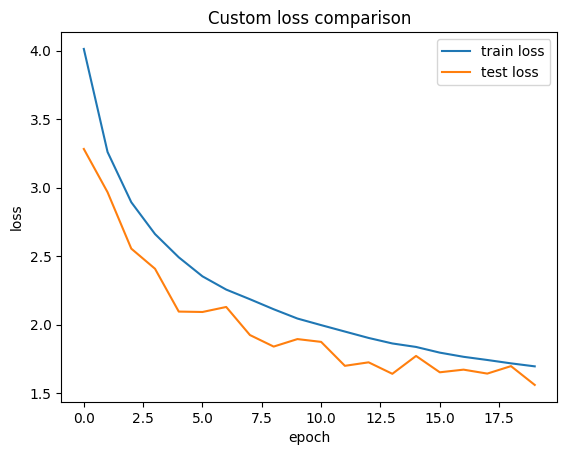

In [27]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'],label='train loss')
plt.plot(hist.history['val_loss'],label='test loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Custom loss comparison')
plt.show()

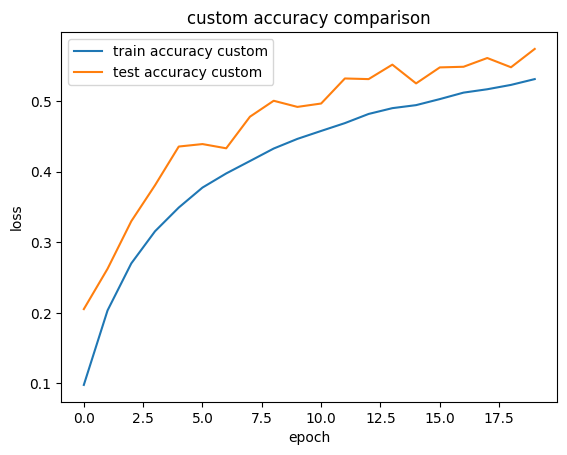

In [28]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'],label='train accuracy custom')
plt.plot(hist.history['val_accuracy'],label='test accuracy custom')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('custom accuracy comparison')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD


(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)


data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])


batch_size = 64

def preprocess(img, label):
    img = tf.cast(img, tf.float32) / 255.0
    img = data_augmentation(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(5000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = test_ds.map(lambda img, label: (tf.cast(img, tf.float32)/255.0, label))
test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


def custom_vgg16_cifar(input_shape=(32,32,3), num_classes=100):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (3,3), padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(512, (3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = GlobalAveragePooling2D()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

model = custom_vgg16_cifar()
model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9, nesterov=True),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

hist1=model.fit(train_ds, validation_data=test_ds, epochs=100, callbacks=callbacks,initial_epoch=33)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,80

 Total params: 34,023,844 (129.79 MB)

 Trainable params: 34,015,396 (129.76 MB)

 Non-trainable params: 8,448 (33.00 KB)

Epoch 34/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 53ms/step - accuracy: 0.0435 - loss: 4.4235 - val_accuracy: 0.1131 - val_loss: 3.8072 - learning_rate: 0.0100
Epoch 35/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.1053 - loss: 3.8059 - val_accuracy: 0.1449 - val_loss: 3.5857 - learning_rate: 0.0100
Epoch 36/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.1479 - loss: 3.5531 - val_accuracy: 0.1923 - val_loss: 3.3403 - learning_rate: 0.0100
Epoch 37/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.1875 - loss: 3.3369 - val_accuracy: 0.1933 - val_loss: 3.3464 - learning_rate: 0.0100
Epoch 38/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.2229 - loss: 3.1521 - val_accuracy: 0.2156 - val_loss: 3.2654 - learning_rate: 0.0100
Epoch 39/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.2547 - loss: 2.9941 - val_accuracy: 0.2726 - val_loss: 2.8772 - learning_rate: 0.0100
Epoch 40/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accura

In [12]:
model.save('vgg_16.keras')

In [13]:
test_loss_vgg, test_acc_vgg = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc_vgg:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5377 - loss: 1.8746
Test Accuracy: 0.5358


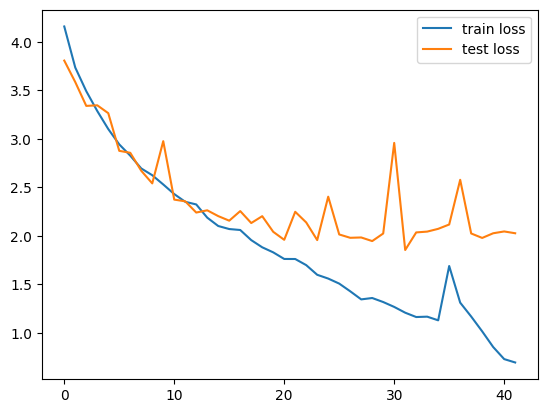

In [14]:
import matplotlib.pyplot as plt

plt.plot(hist1.history['loss'],label='train loss')
plt.plot(hist1.history['val_loss'],label='test loss')
plt.legend()
plt.show()

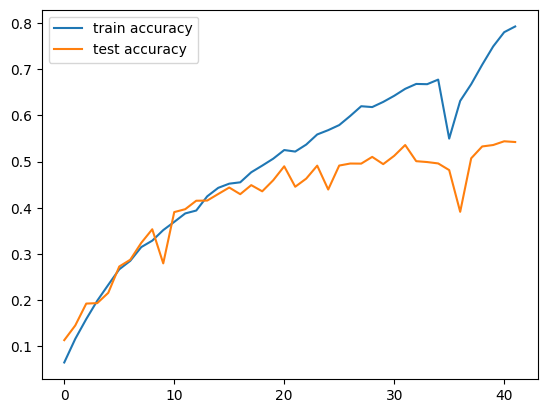

In [15]:
import matplotlib.pyplot as plt

plt.plot(hist1.history['accuracy'],label='train accuracy')
plt.plot(hist1.history['val_accuracy'],label='test accuracy')
plt.legend()
plt.show()

In [35]:
import pandas as pd
data=pd.DataFrame(columns=['model','accuracy'])
data.loc[len(data)]=['Custom model','57.42%']
data.loc[len(data)]=['vgg model','53.58%']

In [36]:
data

,model,accuracy
0,Custom model,57.42%
1,vgg model,53.58%
